In [1]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import random
import math
from math import prod
from math import isclose
import itertools
import cvxpy as cp
import sympy as sp
from scipy.optimize import fsolve
import scipy.linalg as la
from scipy.optimize import minimize, LinearConstraint


## Basic parameters
random_seed = 5 # random_seed 
betamax = 30 # maximum VOT value
R = 3  # 3 routes
W = 3  # 3 states


def simulation_info_design(R,W):
    
    print(f"\nSolving optimal information design problem for R = {R} and W = {W}.")

    # Randomly generate variable m values that meet the conditions
    def generate_m(R):
        random.seed(random_seed) # Set random seed to ensure experiment reproducibility

        # Randomly select R numbers from 1 to 5 and ensure they are in ascending order
        values = sorted(random.sample([round(x * 0.1, 1) for x in range(10, 51)], R))

        # Use a dictionary to store variable names and corresponding values
        m_variables = {f'm{i+1}': values[i] for i in range(R)}

        return m_variables

    # Randomly generate W weights that meet the conditions
    def generate_weights(W):
        random.seed(random_seed)  # Set random seed to ensure experiment reproducibility
        weights = [random.random() for _ in range(W)]
        total = sum(weights)
        normalized_weights = [w / total for w in weights]

        # Use a dictionary to store variable names and corresponding values
        weight_variables = {f'w{i+1}': round(normalized_weights[i], 2) for i in range(W)}

        return weight_variables

    # Randomly generate alpha values ranging from 0 to 1
    def generate_alphas(R, W):
        random.seed(random_seed)  # Set random seed to ensure experiment reproducibility
        alpha_variables = {f'alpha{i+1}{j+1}': round(random.random(), 2) for i in range(R) for j in range(W)}

        return alpha_variables

    m_variables = generate_m(R)

    weight_variables = generate_weights(W)

    alpha_variables = generate_alphas(R, W)

    # Dynamically define tau variables and assign values (equal to the corresponding alpha values)
    tau_variables = {f'tau{i+1}{j+1}': alpha_variables[f'alpha{i+1}{j+1}'] for i in range(R) for j in range(W)}

    # Dynamically define m variables and assign values
    for key, value in m_variables.items():
        globals()[key] = value

    # Dynamically define probability variables and assign values
    for key, value in weight_variables.items():
        globals()[key] = value

    # Dynamically define alpha variables and assign values
    for key, value in alpha_variables.items():
        globals()[key] = value

    # Dynamically define tau variables and assign values
    for key, value in tau_variables.items():
        globals()[key] = value

    # Print directly defined m variables
    for key in m_variables:
        print(f"{key} = {globals()[key]}")

    # Print directly defined probability variables
    for key in weight_variables:
        print(f"{key} = {globals()[key]}")

    # Print directly defined alpha variables
    for key in alpha_variables:
        print(f"{key} = {globals()[key]}")

    # Print directly defined tau variables
    for key in tau_variables:
        print(f"{key} = {globals()[key]}")



    ## 2. Calculate First Best (FB) and Complete Information (CI) Equilibrium 

    # Function to calculate l values
    def calculate_l_values(alpha, tau):
        R = len(alpha)
        l_values = []
        for r in range(R):
            numerator_term1 = 2 * prod([alpha[i] for i in range(R) if i != r])
            numerator_term2 = sum([tau[j] * prod([alpha[i] for i in range(R) if i != r and i != j]) for j in range(R) if j != r])
            numerator_term3 = sum([tau[r] * prod([alpha[i] for i in range(R) if i != r and i != j]) for j in range(R) if j != r])
            numerator = numerator_term1 + numerator_term2 - numerator_term3
            denominator = 2 * sum([prod([alpha[i] for i in range(R) if i != j]) for j in range(R)])
            l_r = numerator / denominator
            l_values.append(l_r)
        return l_values

    # Function to calculate C_r values
    def calculate_C_values(alpha, tau):
        R = len(alpha)
        C_values = []
        for r in range(R):
            term1 = 2 * prod([alpha[i] for i in range(R) if i != r])
            term2 = sum([tau[j] * prod([alpha[i] for i in range(R) if i != r and i != j]) for j in range(R) if j != r])
            term3 = sum([tau[r] * prod([alpha[i] for i in range(R) if i != r and i != j]) for j in range(R) if j != r])
            C_r = term1 + term2 - term3
            C_values.append(C_r)
        return C_values

    # Function to calculate l values based on conditions
    def calculate_fb_equilibrium(alpha, tau, m, betamax):
        R = len(alpha)
        C_values = calculate_C_values(alpha, tau)
        valid_routes = [r for r in range(R) if C_values[r] >= 0]

        if len(valid_routes) == R:
            # Condition from label {22}
            l_values = calculate_l_values(alpha, tau)
        else:
            # Condition from label {23} and label {24}
            R_prime = len(valid_routes)
            alpha_prime = [alpha[r] for r in valid_routes]
            tau_prime = [tau[r] for r in valid_routes]
            l_values = calculate_l_values(alpha_prime, tau_prime)
            # Expand l_values to match original R by setting excluded routes to 0
            full_l_values = [0] * R
            for idx, r in enumerate(valid_routes):
                full_l_values[r] = l_values[idx]
            l_values = full_l_values

        return l_values


    # General function definition for solving complete information equilibrium
    def solve_complete_information_equilibrium(R, W, betamax):
        results = {}
        for w in range(1, W + 1):        
            # 枚举所有子集
            routes = list(range(R))[1:]
            all_subsets = []
            for size in range(1, len(routes)+1):
                for combo in itertools.combinations(routes, size):
                    subset = [0] + list(combo)
                    subset.sort()
                    all_subsets.append(subset)

            for remaining_routes in all_subsets:
                def func(x):
                    equations = []
                    cumulative_l = 0
                    for r_idx, r in enumerate(remaining_routes[:-1]):
                        lval = x[r_idx]
                        cumulative_l += lval
                        l_next = 1 - cumulative_l if r_idx == len(remaining_routes) - 2 else x[r_idx + 1]
                        beta = betamax * cumulative_l
                        eq = (
                            beta*(globals()[f'alpha{r+1}{w}']*lval + globals()[f'tau{r+1}{w}']) + globals()[f'm{r+1}']
                            - beta*(globals()[f'alpha{remaining_routes[r_idx+1]+1}{w}']*l_next
                                    + globals()[f'tau{remaining_routes[r_idx+1]+1}{w}'])
                            - globals()[f'm{remaining_routes[r_idx+1]+1}']
                        )
                        equations.append(eq)
                    return np.array(equations)

                initial_guess = [1 / len(remaining_routes)]*(len(remaining_routes)-1)
                solution_part = fsolve(func, initial_guess)
                solution_part = np.append(solution_part, 1 - sum(solution_part))

                # [新增] 把部分路解还原到 R=4 维度
                flow_full = np.zeros(R)
                for i, rr in enumerate(remaining_routes):
                    flow_full[rr] = solution_part[i]

                def check_valid_load(lvec):
                    vot_values = np.linspace(0, betamax, num=101)
                    route_counts = np.zeros(R, dtype=int)
                    for vot in vot_values:
                        utilities = []
                        for r in range(1, R + 1):
                            cost = globals()[f'm{r}'] + vot*(
                                globals()[f'alpha{r}{w}']*lvec[r-1]
                                + globals()[f'tau{r}{w}']
                            )
                            u = -cost
                            utilities.append(u)
                        chosen_idx = np.argmax(utilities)
                        route_counts[chosen_idx] += 1
                    return route_counts

                # [修改] 改用 flow_full，而不是直接 solution_part
                route_counts = check_valid_load(flow_full)
                # 比较差异
                if np.max(np.abs(flow_full*100 - route_counts)) <= 2:
                    results[f'l{w}ci'] = flow_full
                    # print("Acceptable solution found for subset:", remaining_routes)
                    break  # 如果只需要第一个满足的解，可直接break

        return results


    # Calculate complete information equilibrium
    ci_results = solve_complete_information_equilibrium(R, W, betamax)

    # Print equilibrium results
#     for w in range(1, W + 1):
#         print(f"l{w}ci: {ci_results[f'l{w}ci']}")


    ## 3. Information design section

    # Define objective function and constraints
    def objective(l):
        l = l.reshape((R, W))
        return np.sum([weight_variables[f'w{j+1}'] * l[k, j] * (alpha_variables[f'alpha{k+1}{j+1}'] * l[k, j] + tau_variables[f'tau{k+1}{j+1}'])
                       for j in range(W) for k in range(R)])


    def convert_lci_dict_to_array(lci_dict):
        """
        将 get_complete_info_equilibrium() 返回的字典转换为形状为 (W, R) 的 numpy 数组，
        其中每一行对应一个状态，行的顺序按照字典中 key 中的数字顺序排序（例如 'l1ci', 'l2ci', ...）。
        """
        # 按 key 中数字排序（假定 key 格式为 'l{state}ci'）
        ordered_keys = sorted(lci_dict.keys(), key=lambda k: int(k[1:-2]))
        # 生成数组，每一行对应一个状态的流量列表
        l_ci_array = np.array([lci_dict[key] for key in ordered_keys])
        return l_ci_array

    # Constraint function (default constraints are greater than or equal to 0)
    def auto_constraints():
        cons = []
        # 归一化约束：对每个状态 j，所有路线流量之和等于1
        for j in range(W):
            cons.append({
                'type': 'eq',
                'fun': lambda l, j=j: np.sum(l.reshape((R, W))[:, j]) - 1
            })

        # 将字典 ci_results 转换为 (W, R) 数组
        l_ci = convert_lci_dict_to_array(ci_results)

        # 根据 l_ci 计算每个状态下的 VOT 阈值（beta_threshold）
        beta_threshold = np.zeros((W, R))
        for omega in range(W):
            cum = 0
            for r in range(R):
                cum += l_ci[omega, r]
                beta_threshold[omega, r] = betamax * cum

        # ============== 新增：对前 R-1 个阈值做“升序排名” ==============
        # ranking[r] 是长度W的列表，表示第r个阈值列从小到大的状态索引
        # inverseRanking[r][omega] 表示“状态omega在第r个阈值列中的排名”
        ranking = [[] for _ in range(R-1)]
        inverseRanking = [[0]*W for _ in range(R-1)]

        for r_idx in range(R-1):
            arr = [(omega, beta_threshold[omega, r_idx]) for omega in range(W)]
            arr_sorted = sorted(arr, key=lambda x: x[1])  # 按阈值从小到大
            ranking[r_idx] = [item[0] for item in arr_sorted]
            for rankPos, (om, _) in enumerate(arr_sorted):
                inverseRanking[r_idx][om] = rankPos


        # 自动构造服从性约束
        # 对于每个状态 ω 和每个 r=0,...,R-2（即对比路线 r+1）    
        for r in range(R - 1):                
            for omegaRank in range(W):
                omega = ranking[r][omegaRank]

                # 如果该状态下路线 r+1 的完全信息均衡流量为 0，则不构造对应阈值约束
                if l_ci[omega, r+1] <= 1e-12:
                    continue

                # 在状态 ω 中，找出索引在 0...r 中正流量的最后一个路线（记为 k）
                idx = [i for i in range(r + 1) if l_ci[omega, i] > 1e-12]
                if not idx:
                    continue
                k = idx[-1]

                # print(f"r={r},omega={omega},k={k},beta_threshold={beta_threshold[omega,r]}")


                # 构造式(23a)：对每个 i 从 ω+1 到 W-1
                for iRank in range(omegaRank + 1, W):
                    i = ranking[r][iRank] # 注i（真实状态）起始没必要，我们只需要iRank（排序状态）
                    # print(f"i={i}")
                    lhs = lambda l, omega=omega, r=r, k=k, iRank=iRank: (
                        weights[f'w{omega+1}'] * (
                            betamax * np.sum(l.reshape((R,W))[:r+1,omega]) *
                            (alpha_variables[f'alpha{(k+1)}{(omega+1)}'] * l.reshape((R, W))[k, omega] + tau_variables[f'tau{(k+1)}{(omega+1)}']) +
                            m[f'm{(k+1)}']
                        ) +
                        sum(
                            (lambda j: weights[f'w{j+1}'] * (
                                betamax * np.sum(l.reshape((R,W))[:r+1,omega])  *
                                (alpha_variables[f'alpha{(k+1)}{(j+1)}'] * l.reshape((R, W))[k, j] + tau_variables[f'tau{(k+1)}{(j+1)}']) +
                                m[f'm{(k+1)}']
                            ))(ranking[r][jRank])
                            for jRank in range(iRank, W)
                        )
                    )
                    rhs = lambda l, omega=omega, r=r, iRank=iRank: (
                        weights[f'w{omega+1}'] * (
                            betamax * np.sum(l.reshape((R,W))[:r+1,omega])  *
                            (alpha_variables[f'alpha{(r+2)}{(omega+1)}'] * l.reshape((R, W))[r+1, omega] + tau_variables[f'tau{(r+2)}{(omega+1)}']) +
                            m[f'm{(r+2)}']
                        ) +
                        sum(
                            (lambda j: weights[f'w{j+1}'] * (
                                betamax * np.sum(l.reshape((R,W))[:r+1,omega])  *
                                (alpha_variables[f'alpha{(r+2)}{(j+1)}'] * l.reshape((R, W))[r+1, j] + tau_variables[f'tau{(r+2)}{(j+1)}']) +
                                m[f'm{(r+2)}']
                            ))(ranking[r][jRank])
                            for jRank in range(iRank, W)
                        )
                    )
                    cons.append({
                        'type': 'ineq',
                        'fun': lambda l, lhs=lhs, rhs=rhs: rhs(l) - lhs(l)
                    })

                # 构造式(23b)：对于每个 i 从 ω-1 到 0（降序），以及对于每个 k′ 从 k 到 r
                for iRank in range(omegaRank - 1, -1, -1):
                    i = ranking[r][iRank]

                    for k_prime in range(k, r + 1):
                        lhs = lambda l, omega=omega, r=r, k_prime=k_prime, iRank=iRank: (
                            weights[f'w{omega+1}'] * (
                                betamax * np.sum(l.reshape((R,W))[:r+1,omega]) *
                                (alpha_variables[f'alpha{(k_prime+1)}{(omega+1)}'] * l.reshape((R, W))[k_prime, omega] + tau_variables[f'tau{(k_prime+1)}{(omega+1)}']) +
                                m[f'm{(k_prime+1)}']
                            ) +
                            sum(
                                (lambda j: weights[f'w{j+1}'] * (
                                    betamax * np.sum(l.reshape((R,W))[:r+1,omega]) *
                                    (alpha_variables[f'alpha{(k_prime+1)}{(j+1)}'] * l.reshape((R, W))[k_prime, j] + tau_variables[f'tau{(k_prime+1)}{(j+1)}']) +
                                    m[f'm{(k_prime+1)}']
                                ))(ranking[r][jRank])
                                for jRank in range(iRank, -1, -1)
                            )
                        )
                        rhs = lambda l, omega=omega, r=r, iRank=iRank: (
                            weights[f'w{omega+1}'] * (
                                betamax * np.sum(l.reshape((R,W))[:r+1,omega]) *
                                (alpha_variables[f'alpha{(r+2)}{(omega+1)}'] * l.reshape((R, W))[r+1, omega] + tau_variables[f'tau{(r+2)}{(omega+1)}']) +
                                m[f'm{(r+2)}']
                            ) +
                            sum(
                                (lambda j: weights[f'w{j+1}'] * (
                                    betamax * np.sum(l.reshape((R,W))[:r+1,omega]) *
                                    (alpha_variables[f'alpha{(r+2)}{(j+1)}'] * l.reshape((R, W))[r+1, j] + tau_variables[f'tau{(r+2)}{(j+1)}']) +
                                    m[f'm{(r+2)}']
                                ))(ranking[r][jRank])
                                for jRank in range(iRank, -1, -1)
                            )
                        )
                        cons.append({
                            'type': 'ineq',
                            'fun': lambda l, lhs=lhs, rhs=rhs: lhs(l) - rhs(l)
                        })
        return cons


    # Simplify original inequality constraints into a matrix
    def simplify_constraint_to_matrix_form(weights, alpha, tau, m, betamax):

        # 自动生成 R*W 个符号，名称为 l1_1, l1_2, …, lR_W
        symbol_names = " ".join([f"l{i+1}_{j+1}" for i in range(R) for j in range(W)])
        l_symbols = sp.symbols(symbol_names)
        # 如果只有一个符号，sp.symbols返回的是单个符号，这里保证结果总是列表或元组
        if not isinstance(l_symbols, (list, tuple)):
            l_symbols = [l_symbols]
        l = np.array(l_symbols)

        simplified_constraints = []

        # Process each constraint in the loop
        for con in auto_constraints():
            if con['type'] == 'ineq':
                constraint_expr = con['fun'](l)
                simplified_expr = sp.expand(constraint_expr)
                simplified_constraints.append(simplified_expr)

        return simplified_constraints

    # Print the formalized transformation process
    alpha = {f'alpha{i+1}{j+1}': alpha_variables[f'alpha{i+1}{j+1}'] for i in range(R) for j in range(W)}

    tau = {f'tau{i+1}{j+1}': tau_variables[f'tau{i+1}{j+1}'] for i in range(R) for j in range(W)}

    weights = {f'w{i+1}': weight_variables[f'w{i+1}'] for i in range(W)}

    m = {f'm{i+1}': m_variables[f'm{i+1}'] for i in range(R)}

    simplified_constraints = simplify_constraint_to_matrix_form(weights, alpha, tau, m, betamax)

#     for idx, constraint in enumerate(simplified_constraints):
#         print(f"Formalized constraint expression {idx + 1}: ")
#         print(constraint)

    def flattened_ci_result(ci_results, R, W):
        """
        将 ci_results 中形如 'l1ci','l2ci',... 的键收集到同一个一维数组,
        顺序与原先手工:
          [ci_results['l1ci'][0], ci_results['l2ci'][0], ...]  保持一致。
        返回: numpy array, 长度 R*W
        """
        arr = []
        # 原先你是先把 route=0 对应的 w=1..W 拼起来,
        #   然后 route=1 的 w=1..W 拼, 再 route=2 ...
        for r in range(R):
            for widx in range(1, W+1):
                arr.append(ci_results[f'l{widx}ci'][r])
        return np.array(arr)

    # 使用方式举例:
    arr = flattened_ci_result(ci_results, R, W)
    ci_obj = objective(arr)
    print("Complete information equilibrium objective value:", objective(arr))

    
    def compute_and_print_fb_equilibria(R, W, betamax, verbose=True):
        """
        依次对 w=1..W:
          1) 从 globals() 取 alpha{r+1}{w}, tau{r+1}{w}, m{r+1}
          2) 调用 calculate_fb_equilibrium(...) 得到该状态下的FB流量
          3) 存入 fb_loads[f'l{w}fb'] 并打印

        最后还把所有FB解 flatten 成 (R*W)一维数组, 调用 objective() 打印 FB objective value
        """
        fb_loads = {}

        # 针对每个状态 w=1..W
        for w_idx in range(1, W+1):
            # 收集 alpha, tau, m
            alpha_list = [globals()[f'alpha{r+1}{w_idx}'] for r in range(R)]
            tau_list   = [globals()[f'tau{r+1}{w_idx}']   for r in range(R)]
            m_list     = [globals()[f'm{r+1}']            for r in range(R)]

            # 调用你已有的 calculate_fb_equilibrium(...)
            fb_l_values = calculate_fb_equilibrium(alpha_list, tau_list, m_list, betamax)

            # 存到字典, key例: 'l1fb', 'l2fb' ...
            fb_loads[f'l{w_idx}fb'] = fb_l_values

            # 打印
#             if verbose:
#                 print(f"FB load in state {w_idx}: ", fb_l_values)

        # 组装所有 w 的 FB 解 => 一维数组, 便于调用 objective
        fb_array = []
        for r in range(R):
            for widx in range(1, W+1):
                fb_array.append(fb_loads[f'l{widx}fb'][r])

        fb_array = np.array(fb_array)

        # 调 objective
        fb_obj_val = objective(fb_array)
        if verbose:
            print('FB objective value: ', fb_obj_val)

        return fb_loads, fb_obj_val

    # 示例用法:
    fb_load_dict, fb_obj = compute_and_print_fb_equilibria(R, W, betamax)
    
    
    def build_Q_matrices(simplified_constraints):
        Q_list = []
        y_symbols = [sp.Symbol(f'l{i}_{j}') for i in range(1, R+1) for j in range(1, W+1)] + [1]  # Define y matrix, including [l11, l12, l13, l21, l22, l23, l31, l32, l33, 1]

        for constraint in simplified_constraints:
            # Initialize Q matrix
            Q = sp.zeros(R*W+1, R*W+1)

            # Extract each term in the constraint expression and fill in the Q matrix
            for term in constraint.as_ordered_terms():
                # Check if it is a square term
                if isinstance(term, sp.Mul):
                    coeff, rest = term.as_coeff_Mul()
                    if isinstance(rest, sp.Pow):
                        base, exp = rest.as_base_exp()
                        if exp == 2 and base in y_symbols:
                            idx = y_symbols.index(base)
                            Q[idx, idx] += coeff
                            continue

                coeff, varis = term.as_coeff_mul(*y_symbols)
                indices = [y_symbols.index(var) for var in varis if var in y_symbols]

                if len(indices) == 1:
                    # Handle linear terms
                    idx = indices[0]
                    Q[idx, -1] += coeff / 2
                    Q[-1, idx] += coeff / 2
                elif len(indices) == 2:
                    # Handle cross terms
                    Q[indices[0], indices[1]] += coeff / 2
                    Q[indices[1], indices[0]] += coeff / 2
                elif len(indices) == 0:
                    # Constant terms
                    Q[-1, -1] = constraint.as_ordered_terms()[-1]

            Q_list.append(Q)

        return Q_list

    # Generate Q matrix list
    Q_matrices = build_Q_matrices(simplified_constraints)

#     for idx, Q in enumerate(Q_matrices):
#         print(f"Q matrix {idx + 1}: ")
#         sp.pprint(Q)


    l_ci_array = convert_lci_dict_to_array(ci_results)
    n = R * W          # 共有 R*W 个流量变量
    N = n + 1          # 加上常数项 => N
    # Construct the lifted matrix variable (semidefinite matrix) L = (l11, l12, ..., 1)T @ (l11, l12, ..., 1)
    L = cp.Variable((N, N), PSD=True)

    def build_objective_Q0(R, W, weights, alpha, tau):

        Q0 = np.zeros((N, N))

        # 辅助: 给定 (r,w), 返回该变量在 0..n-1 的索引
        # 这里令 r,w 从 1开始 => idx=(r-1)*W+(w-1)
        def idx(r_, w_):
            return (r_-1)*W + (w_-1)

        for r_ in range(1, R+1):
            for w_ in range(1, W+1):
                # 找到下标 i
                i = idx(r_, w_)
                # 取概率 psi(omega) = weights["w{w_}"]
                w_prob = weights[f"w{w_}"]
                # alpha_{r,w} = alpha[f"alpha{r_}{w_}"]
                alpha_val = alpha[f"alpha{r_}{w_}"]
                # tau_{r,w}   = tau[f"tau{r_}{w_}"]

                # 在对角线加上 alpha_{r,w} * w_prob
                Q0[i,i] += w_prob * alpha_val

                half_coeff = 0.5 * w_prob * tau[f"tau{r_}{w_}"]
                # 线性项 => Q0[i,N-1], Q0[N-1,i] 各加 half_coeff
                Q0[i, n]      += half_coeff
                Q0[n, i]      += half_coeff

        return Q0

    Q0 = build_objective_Q0(R, W, weights, alpha, tau)

    # Construct coefficient matrix Q, vector c, and constant d for constraints
    num_constraints = len(Q_matrices)
    Q = np.zeros((N, N, num_constraints))

    # Constraint: yTQy >= 0
    for num,Q_mat in enumerate(Q_matrices):
        Q[:,:,num] = Q_mat

    # Construct constraint list
    constraints = []

    # Variable range constraints
    constraints += [
        L[i,n] >= 0 for i in range(N) 
    ]
    constraints += [
        L[i,n] <= 1 for i in range(N)
    ]


    # 每条路径的流量都要介于完全信息下最小状态与最大状态之间
    constraints += [L[r*W+w,n]<=np.max(l_ci_array[:,r]) for w in range (W) for r in range(R-1)]
    constraints += [L[r*W+w,n]>=np.min(l_ci_array[:,r]) for w in range (W) for r in range(R-1)]


    # Sum of loads in each state equal to one
    constraints += [np.sum([L[r*W+w,n] for r in range(R)])==1 for w in range(W)]

    # L(-1,-1) == 1 (corresponding to constant term)
    constraints += [L[n,n] == 1]

    # Ensure diagonal elements satisfy L(ii) ≥ L(i0)^2
    constraints += [
        L[i,i] >= cp.square(L[i,0]) for i in range(N-1)
    ]

    # Add linear constraints
    for i in range(num_constraints):
        constraints += [
            cp.trace(Q[:,:,i] @ L) >= 0
        ]

    # Construct the objective function
    obj = cp.Minimize(cp.trace(Q0 @ L))

    # Define and solve the optimization problem
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.MOSEK)
    # prob.solve(solver=cp.SCS)

    if prob.status not in ["infeasible", "unbounded"]:
        N = R*W + 1
        Lval = L.value  # 取数值
#         if Lval is None:
#             print("No solution was found in L.value!")

        # 依次提取 i=0..(R*W-1) => L.value[i, N-1]
        # 并存到一个 shape=(R,W) 的 2D 数组 solution
        solution = []
        for r_idx in range(R):
            row_vals = []
            for w_idx in range(W):
                i = r_idx*W + w_idx
                row_vals.append(Lval[i, N-1])
            solution.append(row_vals)

        # 打印
#         print("SDP relaxed solution is as follows——")
#         for r_idx in range(R):
#             for w_idx in range(W):
#                 print(f"Optimal l_{r_idx+1}^{w_idx+1}: {solution[r_idx][w_idx]}")

        # 最后打印目标函数值
        print(f"Minimum Objective Value Found by SDP: {prob.value}")
        sdp_obj = prob.value

    else:
        print(f"Problem status: {prob.status}. Problem is infeasible or unbounded.")
        
    return ci_obj, fb_obj, sdp_obj
        

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# simulation_main
simulation_list = [(2,2),(2,3),(4,2),(3,4),(4,4),(5,4),(7,3),(7,4)]
efficiency = [] # efficiency improved by information design against complete information equilibrium
for (R,W) in simulation_list:
    ci_obj, fb_obj, sdp_obj = simulation_info_design(R,W)
    efficiency.append(np.abs(sdp_obj-ci_obj)/ci_obj)


Solving optimal information design problem for R = 2 and W = 2.
m1 = 2.6
m2 = 4.9
w1 = 0.46
w2 = 0.54
alpha11 = 0.62
alpha12 = 0.74
alpha21 = 0.8
alpha22 = 0.94
tau11 = 0.62
tau12 = 0.74
tau21 = 0.8
tau22 = 0.94
Complete information equilibrium objective value: 1.1720525534878423
FB objective value:  1.14694708249497
Minimum Objective Value Found by SDP: 1.171712788857215

Solving optimal information design problem for R = 2 and W = 3.
m1 = 2.6
m2 = 4.9
w1 = 0.29
w2 = 0.34
w3 = 0.37
alpha11 = 0.62
alpha12 = 0.74
alpha13 = 0.8
alpha21 = 0.94
alpha22 = 0.74
alpha23 = 0.92
tau11 = 0.62
tau12 = 0.74
tau13 = 0.8
tau21 = 0.94
tau22 = 0.74
tau23 = 0.92
Complete information equilibrium objective value: 1.1937981560795796
FB objective value:  1.1718664281454978
Minimum Objective Value Found by SDP: 1.188504660005621

Solving optimal information design problem for R = 4 and W = 2.
m1 = 2.6
m2 = 3.2
m3 = 4.3
m4 = 4.9
w1 = 0.46
w2 = 0.54
alpha11 = 0.62
alpha12 = 0.74
alpha21 = 0.8
alpha22 = 0.94


In [3]:
print("Compared to the complete information equilibrium, the efficiency under information design improved:")
for eff,net_sz in zip(efficiency,simulation_list):
    print(f"{round(eff*100,2)}% in {net_sz} network.")

Compared to the complete information equilibrium, the efficiency under information design improved:
0.03% in (2, 2) network.
0.44% in (2, 3) network.
0.63% in (4, 2) network.
2.52% in (3, 4) network.
2.96% in (4, 4) network.
7.5% in (5, 4) network.
8.11% in (7, 3) network.
19.1% in (7, 4) network.


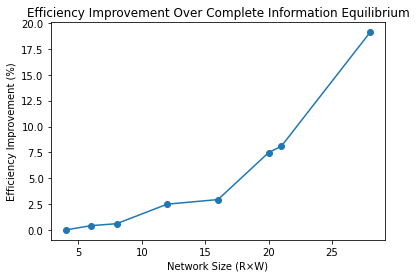

In [4]:
import matplotlib.pyplot as plt

# 将 (R,W) 转化为单个网络规模值 R*W
net_sizes = [r * w for (r, w) in simulation_list]
# 效率提升转化为百分比
eff_percent = [e * 100 for e in efficiency]

# 绘制图表
plt.figure(figsize=(6, 4))  # 可根据需要调节图尺寸 (width, height)
plt.plot(net_sizes, eff_percent, marker='o', linestyle='-', linewidth=1.5)

# 设置坐标轴标签
plt.xlabel("Network Size (R×W)")
plt.ylabel("Efficiency Improvement (%)")

# 设置主标题（可选）
plt.title("Efficiency Improvement Over Complete Information Equilibrium")

# 打开网格, 使图表更易读
plt.grid(False)

# 如果需要在论文中嵌入图片文件，可使用：
# plt.savefig("efficiency_improvement.png", dpi=300, bbox_inches='tight')

# 显示图表
plt.show()
